In [1]:
import matplotlib.pyplot as plt
from matplotlib  import cm
import matplotlib.animation
plt.rcParams.update({'font.size': 8})

%matplotlib ipympl
import numpy as np
import pandas as pd
import random

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import joblib
import time
from numba_progress import ProgressBar
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, lorentzian_distr, get_trajs, speed_windowed, theta_windowed, \
                    get_smooth_trajs, get_velocities

show_verb = False
save_verb = True
anim_show_verb = False

In [2]:
traj_verb = "hough"

if traj_verb == "trackpy": 
    rawTrajs = pd.read_parquet("../tracking/results/tracking_data/trackpy_pre_merge.parquet")
    res_path = "results"
    analysis_data_path = "analysis_data"

elif traj_verb == "hough":
    rawTrajs = pd.read_parquet("../tracking/results/tracking_data/tracking_hough_trackpy_linking.parquet")
    res_path = "hough_results"
    analysis_data_path = "hough_analysis_data"
else:
    raise ValueError("traj_verb must be either 'trackpy' or 'hough'")

red_particle_idx = 17
colors = rawTrajs.loc[rawTrajs.frame == 0, 'color'].values
nDrops = int(len(rawTrajs.loc[rawTrajs.frame==0]))
nFrames = int(max(rawTrajs.frame) + 1)
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")

# Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, 30, 2)

# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")

# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 288


# NEW UPDATES 

In [ ]:
# select 100 frames from the trajectory of  particle id = 10
test = smoothTrajs.loc[(smoothTrajs.frame.between(0, 30000)) & (smoothTrajs.particle == 10)]

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
scatter = ax.scatter(test.x, test.y, c = np.arange(0, 30001, 1), s = .1, cmap = cm.jet)
ax.set(xlabel="x [px]", ylabel="y [px]", title = "Trajectory of particle id = 10", xlim=(0, 900), ylim=(0, 900))
ax.grid(True, linestyle='-', color = '0.75')
ax.legend(*scatter.legend_elements(), title = "Time", fontsize = 8, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

## CHECK BALLISTIC REGIME BETWEEN 0-1 S - FOR SMOOTH TRAJECTORIES

note that ballistic motion msd has pw exponent 2 !!!

In [ ]:
x = np.arange(0, 10000, 0.1)
y = 10*x + 2*x**2
# compute msd
max_lagtime = 1000
msd = np.zeros(max_lagtime-1)
for lagtime in range(1, max_lagtime):
    msd[lagtime-1] = np.mean((y[lagtime:] - y[:-lagtime])**2 + (x[lagtime:] - x[:-lagtime])**2)
# fit msd with power law
def power_law(x, a, b):
    return a*x**b
popt, pcov = curve_fit(power_law, np.arange(1, max_lagtime), msd, p0 = (1, 1))
print(f"fit parameters: {popt}")

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(np.arange(1, max_lagtime), msd)
ax.set(xlabel="lagtime", ylabel="msd", title = "MSD of a parabola")
ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

In [ ]:
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered
#x = np.array(imsd[1:].index)
x = np.arange(1., 100.1, .1)
imsd, fit, pw_exp, fit_ball, pw_exp_ball = get_imsd(smoothTrajs, pxDimension, fps, maxLagtime, nDrops)

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 4))
ax.plot(imsd.index, imsd, '.',  markersize = 1)
ax.plot(imsd[:1].index, fit_ball.T, linewidth = 1)
ax.plot(imsd[1:].index, fit.T, linewidth = 1)
ax.set(xlabel="lag time [s]", ylabel="MSD [px$^2$]", xscale = "log", yscale = "log", xlim=(0.01, 10))
ax.grid(True, linestyle='-', color = '0.75')

ax1.errorbar(np.arange(0, nDrops, 1), pw_exp_ball[:, 0, 1], yerr = pw_exp_ball[:, 1, 0], fmt = '.', markersize = 5, label = "ballistic")
ax1.errorbar(np.arange(0, nDrops, 1), pw_exp[:, 0, 1], yerr = pw_exp_ball[:, 1, 0], fmt = '.', markersize = 5, label = "diffusive")
ax1.set(xlabel="Droplet ID", ylabel="Pw exponent")
ax1.grid(True, linestyle='-', color = '0.75')
ax1.legend()
plt.tight_layout()
plt.show()

In [ ]:
MSD_b, MSD_r, diffusive_results, ballistic_results = get_emsd(imsd, x, red_particle_idx, nDrops)
fit_b_ball, pw_exp_b_ball = ballistic_results["fit_b"], ballistic_results["pw_exp_b"]
fit_b_diff, pw_exp_b_diff = diffusive_results["fit_b"], diffusive_results["pw_exp_b"]
fit_r_ball, pw_exp_r_ball = ballistic_results["fit_r"], ballistic_results["pw_exp_r"]
fit_r_diff, pw_exp_r_diff = diffusive_results["fit_r"], diffusive_results["pw_exp_r"]

In [ ]:
a_ball = [round(pw_exp_b_ball[0, 1], 3), round(pw_exp_b_ball[1, 1], 3)]
b_ball = [round(pw_exp_r_ball[0, 1], 3), round(pw_exp_r_ball[1, 1], 3)]
print(f"Smooth trajs - Ballistic - Blue Particles: {a_ball[0]} ± {a_ball[1]}, Red Particle: {b_ball[0]} ± {b_ball[1]}")

a_diff = [round(pw_exp_b_diff[0, 1], 3), round(pw_exp_b_diff[1, 1], 3)]
b_diff = [round(pw_exp_r_diff[0, 1], 3), round(pw_exp_r_diff[1, 1], 3)]
print(f"Smooth trajs - Diffusive - Blue Particles: {a_diff[0]} ± {a_diff[1]}, Red Particle: {b_diff[0]} ± {b_diff[1]}")

fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(imsd.index, MSD_b[0], 'b-', label = "Blue particles") 
ax.plot(imsd[1:].index, fit_b_diff, 'b--', label = f"Diffusive Region: {a_diff[0]} ± {a_diff[1]}")
ax.plot(imsd[:1].index, fit_b_ball, 'b:', label = f"Ballistic Region: {a_ball[0]} ± {a_ball[1]}")
ax.fill_between(imsd.index, MSD_b[0] - MSD_b[1], MSD_b[0] + MSD_b[1], alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(imsd.index, MSD_r, 'r-', label = "Red particle")
ax.plot(imsd[1:].index, fit_r_diff, 'r--', label = f"Diffusive Region: {b_diff[0]} ± {b_diff[1]}")
ax.plot(imsd[:1].index, fit_r_ball, 'r:', label = f"Ballistic Region: {b_ball[0]} ± {b_ball[1]}")
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
        xlabel = 'lag time $t$ [s]', title = "EMSD - Smooth Trajectories")
ax.legend()
ax.grid()
plt.savefig(f"./{res_path}/mean_squared_displacement/ballistic_region/EMSD_smoothTrajs.png", bbox_inches = 'tight')
plt.show()

# DROPLET SIZE VS THINGS

In [ ]:
# mean and std droplet diameter per frame
hough_df = pd.read_parquet("../tracking/results/tracking_data/tracking_hough_trackpy_linking.parquet")
display(hough_df)
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
for i in range(50):
    ax.plot(hough_df[hough_df.particle == i].frame, hough_df[hough_df.particle == i].d, alpha = 0.5, linewidth = 0.5)
ax.set(xlabel = "Frame", ylabel = "Droplet radius [px]", title = "Droplet radius per frame")
ax.grid()
plt.show()

In [ ]:
# mean and std droplet diameter per frame
d_wind = np.zeros((nSteps, nDrops))
d_wind_std = np.zeros((nSteps, nDrops))
for i, start in enumerate(startFrames):
    hough_wind = hough_df.loc[hough_df.frame.between(start, start+window)]
    for j in range(nDrops):
        temp = hough_wind.loc[hough_wind.particle == j].d.values
        d_wind[i, j] = np.nanmean(temp)
        d_wind_std[i, j] = np.nanstd(temp)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
for i in range(nDrops):
    ax.plot(startFrames/10, d_wind[:, i], linewidth = 0.8)
ax.set(xlabel = "Window time [s]", ylabel = "Droplet radius [px]", title = "Droplet radius per frame")
ax.grid()
plt.show()

In [ ]:
show_verb = False
run_windowed_analysis = True
plot_verb = False
animated_plot_verb = False
print(f"MSD Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")

%run ./analysis_modules/msd.ipynb

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
for i in range(nDrops):
    ax.errorbar(startFrames/10, pw_exp_wind[:, i, 0, 1], yerr = pw_exp_wind[:, i, 1, 1], fmt = 'o', linewidth = 0.5, markersize = 2)
ax.set(xlabel = "Window time [s]", ylabel = r'$\alpha$')
ax.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
for i in range(nDrops):
    scatter = ax.scatter(d_wind[:, i], pw_exp_wind[:, i, 0, 1], s= 5, c = startFrames/10, marker = 'o', cmap = cm.Blues)
ax.set(ylabel = "Pw exponent", xlabel = "Droplet radius [px]", title = "Droplet radius per frame")
ax.grid()
fig.legend(*scatter.legend_elements(), title = "Window Time", fontsize = 8, loc=7)
plt.show()

## mean radius

In [ ]:
mean_d = hough_df.groupby("frame").mean().d.values
std_d = hough_df.groupby("frame").std().d.values

# mean and std droplet diameter per frame
mean_d_wind = np.zeros(nSteps)
std_d_wind = np.zeros(nSteps)
for i, start in enumerate(startFrames):
    mean_d_wind[i] = np.nanmean(mean_d[start:start+window])
    std_d_wind[i] = np.nanstd(mean_d[start:start+window])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(np.arange(0, nFrames, 1)/10, mean_d)
ax.fill_between(np.arange(0, nFrames, 1)/10, mean_d - std_d, mean_d + std_d, alpha=0.5)
ax.set(xlabel = "Time [s]", ylabel = "d [px]", title = "Droplet radius over time")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(startFrames/10, mean_d_wind)
ax.fill_between(startFrames/10, mean_d_wind - std_d_wind, mean_d_wind + std_d_wind, alpha=0.5)
ax.set(xlabel = "Window Time [s]", ylabel = "d [px]", title = "Droplet radius over window time")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

### vs Velocity Variance

In [ ]:
show_verb = False
run_windowed_analysis = False
overwrite = False
animated_plot_verb = False

print(f"Velocity Autocorrelation Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/velocity_autocorrelation.ipynb

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)
scatter = ax.scatter(vacf_b_wind["0"], mean_d_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter1 = ax.scatter(vacf_r_wind["0"], mean_d_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax.set(title = "Raw Trajs", xlabel = r"$\sigma_v^2$", ylabel = "d [px]" )
ax.grid(True, linestyle='-', color = '0.75')

scatter2 = ax1.scatter(vacf_b_wind_smooth["0"], mean_d_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter3 = ax1.scatter(vacf_r_wind_smooth["0"], mean_d_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax1.set(title = "Smooth Trajs", xlabel = r"$\sigma_v^2$", ylabel = "d [px]")
ax1.grid(True, linestyle='-', color = '0.75')

fig.suptitle("Velocity Variance vs. Mean Radius")
fig.legend(*scatter3.legend_elements(), title = "Window Time", fontsize = 8, loc = 7)
fig.tight_layout()
fig.subplots_adjust(right=1)
if save_verb: plt.savefig(f'./{res_path}/distance_scatterplots/v_variance.png', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

### vs Effective Temperature from velocity distribution

In [ ]:
show_verb = False
animated_plot_verb = False
print(f"Speed and Turning Angles Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/velocity_distr.ipynb

In [ ]:
eff_T_speed_b = blue_fit_wind[:, 0]
eff_T_speed_b_sigma = blue_fit_wind[:, 1]
eff_T_speed_r = red_fit_wind[:, 0]
eff_T_speed_r_sigma = red_fit_wind[:, 1]

eff_T_speed_b_smooth = blue_fit_wind_smooth[:, 0]
eff_T_speed_b_sigma_smooth = blue_fit_wind_smooth[:, 1]
eff_T_speed_r_smooth = red_fit_wind_smooth[:, 0]
eff_T_speed_r_sigma_smooth = red_fit_wind_smooth[:, 1]

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)
scatter = ax.scatter(eff_T_speed_b, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter1 = ax.scatter(eff_T_speed_r, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax.set(title = "Raw Trajs", xlabel = r"$T_{eff} \; [??]$", ylabel = "d [px]")
ax.grid(True, linestyle='-', color = '0.75')

scatter2 = ax1.scatter(eff_T_speed_b_smooth, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter3 = ax1.scatter(eff_T_speed_r_smooth, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax1.set(title = "Smooth Trajs", xlabel = r"$T_{eff} \; [??]$", ylabel = "d [px]")
ax1.grid(True, linestyle='-', color = '0.75')

fig.suptitle("Effective Temperature vs. Mean Radius")
fig.legend(*scatter3.legend_elements(), title = "Window Time", fontsize = 8, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=1)
plt.tight_layout()
if save_verb: plt.savefig(f'./{res_path}/distance_scatterplots/eff_T.png', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

### vs Power law exponent from msd 

In [ ]:
pw_b = fit_dict["pw_exp_wind_b"][:, 0, 1]
pw_b_std = fit_dict["pw_exp_wind_b"][:, 1, 1]
pw_r = fit_dict["pw_exp_wind_r"][:, 0, 1]
pw_r_std = fit_dict["pw_exp_wind_r"][:, 1, 1]

pw_b_smooth = fit_dict_smooth["pw_exp_wind_b"][:, 0, 1]
pw_b_std_smooth = fit_dict_smooth["pw_exp_wind_b"][:, 1, 1]
pw_r_smooth = fit_dict_smooth["pw_exp_wind_r"][:, 0, 1]
pw_r_std_smooth = fit_dict_smooth["pw_exp_wind_r"][:, 1, 1]

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)
scatter = ax.scatter(pw_b, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter1 = ax.scatter(pw_r, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax.set(title = "Raw Trajs", xlabel =  "pw exponent", ylabel = "d [px]")
ax.grid(True, linestyle='-', color = '0.75')

scatter2 = ax1.scatter(pw_b_smooth, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter3 = ax1.scatter(pw_r_smooth, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax1.set(title = "Smooth Trajs", xlabel = "pw exponent", ylabel = "d [px]")
ax1.grid(True, linestyle='-', color = '0.75')

fig.suptitle("Power Law Exponent vs. Mean Radius")
fig.legend(*scatter3.legend_elements(), title = "Window Time", fontsize = 8, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=1)
plt.tight_layout()
if save_verb: plt.savefig(f'./{res_path}/distance_scatterplots/pw_law.png', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# 3 body

sigma direi di usare il diametro, per b direi [0 - 3 sigma] a step non superiori a 0.2 sigma.

In [9]:
@njit
def compute_bin(x, bin_edges):
    # assuming uniform bins for now
    n = bin_edges.shape[0] - 1
    a_min = bin_edges[0]
    a_max = bin_edges[-1]
    # special case to mirror NumPy behavior for last bin
    if x == a_max:
        return n - 1 # a_max always in last bin
    bin = int(n * (x - a_min) / (a_max - a_min))
    if bin < 0 or bin >= n:
        return None
    else:
        return bin
@njit
def numba_histogram(a, bin_edges, weights):
    hist = np.zeros((len(bin_edges)-1,), dtype=np.intp)
    for ind, x in enumerate(a):
        bin = compute_bin(x, bin_edges)
        if bin is not None:
            hist[int(bin)] += weights[ind]
    return hist

@njit
def numba_mean_ax0(a):
    res = []
    for i in prange(a.shape[1]):
        res.append(a[:, i].mean())
    return np.array(res)



# this doesn't work
@njit(parallel = True)
def three_body_frame(coords, bList, sigma, hist_bins):
    """
    Computes the three body distribution for a single frame
    coords : array of shape (nDrops, 3)
        The coordinates of the drops
    bList : array of shape (nB)
        The b values to compute the three body distribution for
    sigma : float   
        The standard deviation of the gaussian used to weight the three body distribution
    hist_bins : array of shape (nBins)
        The bins to compute the three body distribution for
    Returns 
    ------- 
    mean_3_body : array of shape (nB, nBins)
        The mean three body distribution for each b value
    """
    res = np.ones((len(bList), len(hist_bins)-1))
    three_body = np.ones((nDrops, len(hist_bins)-1))
    angles = np.ones(int((nDrops-1)*(nDrops-2)/2))
    gauss_weights = np.zeros(int((nDrops-1)*(nDrops-2)/2))
    for b_ind in prange(len(bList)):
        b = bList[b_ind]
        for i in prange(nDrops):
            count = 0
            r_i = coords[i]
            for j in range(nDrops):
                if i == j:
                    continue
                r_ij = coords[j] - r_i
                for k in range(j+1, nDrops):
                    if k == i:
                        continue
                    r_ik = coords[k] - r_i
                    angles[count] = np.arccos(np.dot(r_ij, r_ik) / (np.linalg.norm(r_ij) * np.linalg.norm(r_ik)))
                    gauss_weights[count] = np.exp(-0.5*((np.linalg.norm(r_ij)-b)/sigma)**2) * np.exp(-0.5*((np.linalg.norm(r_ik)-b)/sigma)**2)
                    count += 1
            three_body[i] = numba_histogram(angles, hist_bins, gauss_weights)
        res[b_ind] = numba_mean_ax0(three_body)
    return res

@njit(parallel = True)
def three_body_frame_modified(coords, bList, sigma, hist_bins):
    angles = np.ones((len(bList), nDrops, int((nDrops-1)*(nDrops-2)/2)))
    gauss_weights = np.ones((len(bList), nDrops, int((nDrops-1)*(nDrops-2)/2)))
    for b_ind in prange(len(bList)):
        b = bList[b_ind]
        for i in range(nDrops):
            count = 0
            r_i = coords[i]
            for j in range(nDrops):
                if i == j:
                    continue
                r_ij = coords[j] - r_i
                for k in range(j+1, nDrops):
                    if k == i:
                        continue
                    r_ik = coords[k] - r_i
                    angles[b_ind, i, count] = np.arccos(np.dot(r_ij, r_ik) / (np.linalg.norm(r_ij) * np.linalg.norm(r_ik)))
                    gauss_weights[b_ind, i, count] = np.exp(-0.5*((np.linalg.norm(r_ij)-b)/sigma)**2) * np.exp(-0.5*((np.linalg.norm(r_ik)-b)/sigma)**2)
                    count += 1
    return angles, gauss_weights

In [ ]:
# test 1 --> doesn't work, problem in three_body_frame
if 0:
    COORDS = np.array(rawTrajs.loc[:,["x","y"]])
    sigma = 38
    bList = np.arange(0, 3*sigma, .2)
    print("bList length: ", bList.shape[0])
    frames = np.arange(0, 30000, 1, dtype = int)
    nFrames = len(frames)

    hist_bins = np.arange(0, np.pi, np.pi/100)
    mean_3_body = np.zeros((nFrames, len(bList), len(hist_bins)-1))

    for frame_ind in tqdm(range(nFrames)):
        mean_3_body[frame_ind] = three_body_frame(COORDS[frames[frame_ind]:frames[frame_ind]+50], bList, sigma, hist_bins)
            
    # save to txt frames, bList and hist bins
    if 1:
        np.savetxt(f"./{analysis_data_path}/3_body/frames.txt", frames)
        np.savetxt(f"./{analysis_data_path}/3_body/bList.txt", bList)
        np.savetxt(f"./{analysis_data_path}/3_body/hist_bins.txt", hist_bins)
        for i, b in enumerate(bList):
            temp = pd.DataFrame(mean_3_body[:, i])
            temp.columns = [str(i) for i in temp.columns]
            temp.to_parquet(f"./{analysis_data_path}/3_body/mean_3_body_{b}.parquet")
else:
    frames = np.loadtxt(f"./{analysis_data_path}/3_body/frames.txt").astype(int)
    nFrames = len(frames)
    bList = np.loadtxt(f"./{analysis_data_path}/3_body/bList.txt")#.astype(int)
    hist_bins = np.loadtxt(f"./{analysis_data_path}/3_body/hist_bins.txt")
    mean_3_body = np.zeros((nFrames, len(bList), len(hist_bins)-1))
    for i, b in enumerate(bList):
        mean_3_body[:, i] = pd.read_parquet(f"./{analysis_data_path}/3_body/mean_3_body_{b}.parquet").values

In [6]:

# test 2 --> seems to work with three_body_frame_modified function
COORDS = np.array(rawTrajs.loc[:,["x","y"]])
sigma = 38
# for thest_3body.parquet
# bList = np.arange(0, 3*sigma + 1, 3*sigma/50) # step 0.2 too little --> 448 hours to complete 30k frames
# for thest_3body_2.parquet
bList = np.arange(0, 300, 300/50) 
print("bList length: ", bList.shape[0])
hist_bins = np.arange(0, np.pi, np.pi/100)
hist_centers = (hist_bins[:-1] + hist_bins[1:])/2
# frames = np.arange(0, 30000, 10) for test
if 0:
    counts = np.zeros((len(frames), len(bList), nDrops, len(hist_bins)-1))
    for frame_ind in tqdm(range(len(frames))):
        test_ang, test_weights = three_body_frame_modified(COORDS[frames[frame_ind]:frames[frame_ind]+50], bList, sigma, hist_bins)
        for b_ind in range(len(bList)):
            for i in range(nDrops):
                counts[frame_ind, b_ind, i] = np.histogram(test_ang[b_ind, i], bins = hist_bins, weights = test_weights[b_ind, i])[0]
    test_reshape = counts.reshape((len(bList)*nDrops*(len(hist_bins)-1), len(frames)))
    test_df = pd.DataFrame(test_reshape)
    test_df.columns = frames.astype(str)
    test_df.to_parquet(f"./{analysis_data_path}/3_body/test_3body.parquet")
else:
    try: 
        print("Importing data...")
        test_df = pd.read_parquet(f"./{analysis_data_path}/3_body/test_3body2.parquet")
        frames = test_df.columns.astype(int)
        counts = np.array(test_df).reshape((len(frames), len(bList), nDrops, len(hist_bins)-1))
        mean_3_body = np.mean(counts, axis = 2)
    except:
        raise Exception("File not found")

bList length:  50
Importing data...
300


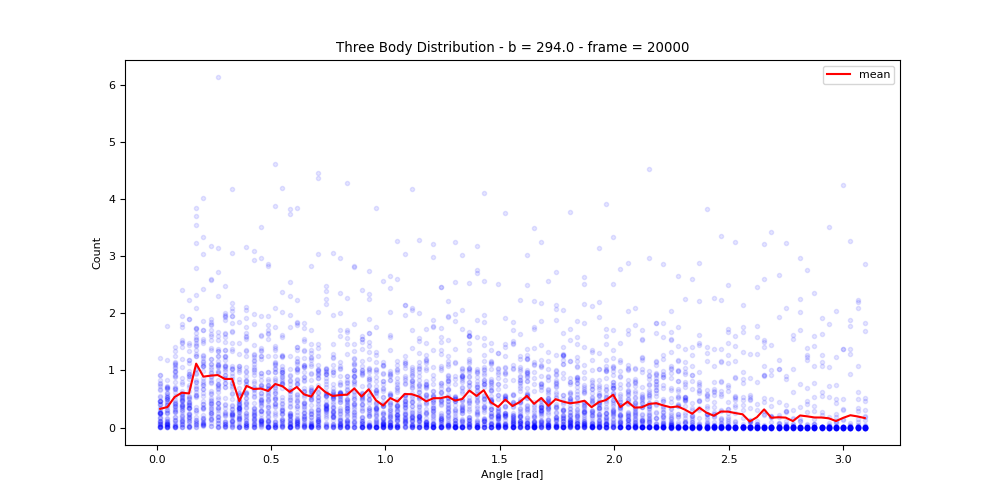

In [7]:
b_ind = -1
frame_ind = 200
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(hist_centers, counts[frame_ind, b_ind].T, 'b.', alpha = 0.1)
ax.plot(hist_centers, mean_3_body[frame_ind, b_ind], color = "r", label = "mean")
ax.set(title = f"Three Body Distribution - b = {bList[b_ind]} - frame = {frames[frame_ind]}", xlabel = "Angle [rad]", ylabel = "Count")
ax.legend()
plt.show()

16:04:00 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
16:04:00 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 500x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ./hough_results/3body/3_body_mean_test2.mp4


IndexError: index 300 is out of bounds for axis 0 with size 300

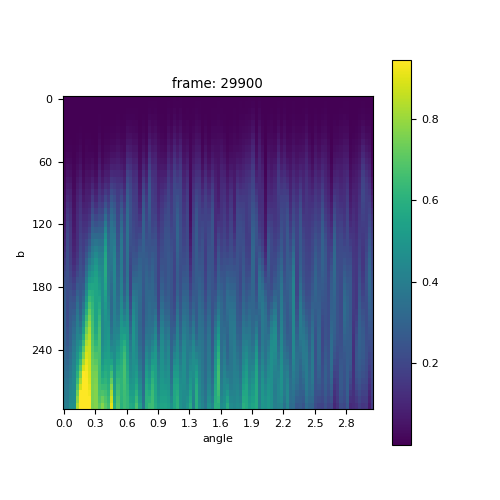

16:05:26 [ERROR] Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x15b660f10>>
Traceback (most recent call last):
  File "/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/matplotlib/backend_bases.py", line 1198, in _on_timer
    ret = func(*args, **kwargs)
  File "/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/matplotlib/animation.py", line 1406, in _step
    still_going = super()._step(*args)
  File "/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/matplotlib/animation.py", line 1105, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/matteoscandola/miniconda3/envs/pyenv3/lib/python3.10/site-packages/matplotlib/animation.py", line 1124, in _draw_next_frame
    self._draw

In [ ]:
"""
frame = 10
fig, ax = plt.subplots(1, 1)
im = ax.imshow(counts[frame])
ax.set(ylabel="b", xlabel="angle", title=f"frame {frame}")
ax.set_xticklabels([f"$\pi$ /{i}" for i in range(10)])
ax.set_yticklabels(bList.astype(int))
fig.colorbar(im, ax=ax)
ax.set_aspect(1.8)
plt.show()
"""

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
anim_running = True
def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

im = ax.imshow(mean_3_body[0])
ax.set(ylabel = "b", xlabel = "angle")
title = ax.set_title(f"frame: {0}")

ax.set_xticks(np.arange(0, len(hist_bins), 10))
ax.set_xticklabels(np.round(hist_bins,1)[::10])
ax.set_yticks(np.arange(0, len(bList), 10))
ax.set_yticklabels(bList.astype(int)[::10])
ax.set_aspect(2)
fig.colorbar(im, ax=ax)

def animate_func(i):
    im.set_array(mean_3_body[i])
    title.set_text(f"frame: {frames[i]}")
    return [im]

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate_func, nFrames, interval = 100)
ani.save(f'./{res_path}/3body/3_body_mean_test2.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()

# CUMULATIVE TURNING ANGLES

In [ ]:
nFrames = max(smoothTrajs.frame)

blueTrajs, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)
theta_blue = np.zeros((nDrops-1, nFrames-1))
for i in range(nDrops-1):
    theta_blue[i] = ys.turning_angles_ensemble([blueTrajs[i]], centered = True, accumulate = False)
theta_red = ys.turning_angles_ensemble(redTraj, centered = True, accumulate = False)

# cumulative turning angles
theta_blue_cum = np.cumsum(theta_blue, axis=1)
theta_red_cum = np.cumsum(theta_red)

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax.plot(np.arange(0, nFrames-1)/10, np.mean(theta_blue_cum, axis = 0), 'b-', label = "Blue droplets")
ax.set(title = "Cumulative turning angles", ylabel = r"$\theta$ [rad]")
ax.grid(True, linestyle='-', color = '0.75')
ax.legend(loc = "upper left")
ax1.plot(np.arange(0, nFrames-1)/10, theta_red_cum, 'r-', label = "Red droplet")
ax1.set(xlabel = "Time [s]", ylabel = r"$\theta$ [rad]")
ax1.grid(True, linestyle='-', color = '0.75')
ax1.legend(loc = "upper left")
plt.tight_layout()
plt.savefig(f"./{res_path}/turning_angles/cumulative_turning_angles.png", bbox_inches = "tight")
plt.show()

In [ ]:
ax.get_legend_handles_labels()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
blue = ax.plot(np.arange(0, nFrames-1)/10, theta_blue_cum.T, linewidth = 0.5, alpha = 0.5, color = 'b')
red = ax.plot(np.arange(0, nFrames-1)/10, theta_red_cum, 'r-')
ax.set(title = "Individual cumulative turning angles", ylabel = r"$\theta$ [rad]", xlabel = "Time [s]")
ax.grid(True, linestyle='-', color = '0.75')
plt.savefig(f"./{res_path}/turning_angles/individual_cumulative_turning_angles.png", bbox_inches = "tight")
plt.show()

In [ ]:
blueTrajs, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)
theta_blue = np.zeros((nDrops-1, nFrames))
for i in range(nDrops-1):
    theta_blue[i] = ys.turning_angles_ensemble([blueTrajs[i]], centered = True, accumulate = True)
theta_red = ys.turning_angles_ensemble(redTraj, centered = True, accumulate = True)

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax.plot(np.arange(0, nFrames)/10, np.mean(theta_blue, axis = 0), 'b-', label = "Blue droplets")
ax.set(title = "Cumulative turning angles - with accumulate = True", ylabel = r"$\theta$ [rad]")
ax.grid(True, linestyle='-', color = '0.75')
ax.legend(loc = "upper left")
ax1.plot(np.arange(0, nFrames)/10, theta_red, 'r-', label = "Red droplet")
ax1.set(xlabel = "Time [s]", ylabel = r"$\theta$ [rad]")
ax1.grid(True, linestyle='-', color = '0.75')
ax1.legend(loc = "upper left")
plt.tight_layout()
plt.show()

# MEAN SQUARED ANGULAR DIFFERENCE

In [ ]:
def get_msad(maxLagtime, r):
    current_msd = np.empty(maxLagtime)
    for lag_ in prange(1, maxLagtime + 1):
        x_ = np.sum(r[lag_:] * r[:-lag_], axis=1) / (np.linalg.norm(r[lag_:], axis=1)*np.linalg.norm(r[:-lag_], axis=1))
        temp = np.arccos( np.clip(x_, -1, 1) )
        current_msd[lag_ - 1] = np.mean(temp)
    return current_msd

In [ ]:
# mean squared angular displacement 
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
maxLagtime = 1000
msad = np.empty((len(blueTrajs), maxLagtime))
for i in tqdm(range(len(blueTrajs))):
    r = np.array(blueTrajs[i].r)
    current_msd = get_msad(maxLagtime, r)
    msad[i] = current_msd
msad_b = np.mean(msad, axis=0)
msad_b_std = np.std(msad, axis=0)

msad_r = get_msad(maxLagtime, np.array(redTraj[0].r))

In [ ]:
msad_b.shape

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, maxLagtime+1, 1)/10, msad_b, 'b', label="blue")
ax.plot(np.arange(1, maxLagtime+1, 1)/10, msad_r, 'r', label="red")
ax.legend()
ax.grid()
ax.set(xlabel="lag [s]", ylabel="MSAD ", xscale="log", yscale="log")
plt.show()

# VELOCITY CORRELATION

In [ ]:
@njit(parallel=True, fastmath=True)
def get_corr(velocities, maxLagtime_):
    xx = np.zeros((velocities.shape[0], maxLagtime_))
    yy = np.zeros((velocities.shape[0], maxLagtime_))
    xy = np.zeros((velocities.shape[0], maxLagtime_))
    for i in prange(velocities.shape[0]):
        v = velocities[i]
        xx[i, 0] = np.corrcoef(v[0], v[0])[0, 1]
        yy[i, 0] = np.corrcoef(v[1], v[1])[0, 1]
        xy[i, 0] = np.corrcoef(v[0], v[1])[0, 1]
        
        for lag_ in prange(1, maxLagtime_):
            xx[i, lag_] = np.corrcoef(v[0, :-lag_], v[0, lag_:])[0, 1]
            yy[i, lag_] = np.corrcoef(v[1, :-lag_], v[1, lag_:])[0, 1]
            xy[i, lag_] = np.corrcoef(v[0, :-lag_], v[1, lag_:])[0, 1]
    return xx, yy, xy

def corr_windowed(nSteps, maxLagtime, startFrames, endFrames, trajectories, red_particle_idx, nDrops):
    corr_b = np.zeros((nSteps, 3, maxLagtime))
    corr_std_b = np.zeros((nSteps, 3, maxLagtime))
    corr_r = np.zeros((nSteps, 3, maxLagtime))
    corr_std_r = np.zeros((nSteps, 3, maxLagtime))

    for k in tqdm(range(nSteps)):
        trajs = trajectories.loc[trajectories.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, trajs)

        res = np.array(get_corr(get_velocities(blueTrajs), maxLagtime))
        corr_b[k], corr_std_b[k] = res.mean(axis=1), res.std(axis=1)
        
        res = np.array(get_corr(get_velocities(redTraj), maxLagtime))
        corr_r[k], corr_std_r[k] = res.mean(axis=1), res.std(axis=1)

    return corr_b, corr_std_b, corr_r, corr_std_r

In [ ]:
if 0:
    maxLagtime = 300
    corr_b, corr_std_b, corr_r, corr_std_r = corr_windowed(nSteps, maxLagtime, startFrames, endFrames, rawTrajs, red_particle_idx, nDrops)

    windLenght = 10
    polyOrder = 2
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, windLenght, polyOrder)
    corr_b_smooth, corr_std_b_smooth, corr_r_smooth, corr_std_r_smooth = corr_windowed(nSteps, maxLagtime, startFrames, endFrames, smoothTrajs, red_particle_idx, nDrops)
    if 1:
        path = f"./{analysis_data_path}/corr/raw/"
        pd.DataFrame(corr_b[:,0]).to_csv(path+"corr_b_x.csv", index=False)
        pd.DataFrame(corr_b[:,1]).to_csv(path+"corr_b_y.csv", index=False)
        pd.DataFrame(corr_b[:,2]).to_csv(path+"corr_b_xy.csv", index=False)
        pd.DataFrame(corr_std_b[:,0]).to_csv(path+"corr_std_b_x.csv", index=False)
        pd.DataFrame(corr_std_b[:,1]).to_csv(path+"corr_std_b_y.csv", index=False)
        pd.DataFrame(corr_std_b[:,2]).to_csv(path+"corr_std_b_xy.csv", index=False)
        pd.DataFrame(corr_r[:,0]).to_csv(path+"corr_r_x.csv", index=False)
        pd.DataFrame(corr_r[:,1]).to_csv(path+"corr_r_y.csv", index=False)
        pd.DataFrame(corr_r[:,2]).to_csv(path+"corr_r_xy.csv", index=False)
        pd.DataFrame(corr_std_r[:,0]).to_csv(path+"corr_std_r_x.csv", index=False)
        pd.DataFrame(corr_std_r[:,1]).to_csv(path+"corr_std_r_y.csv", index=False)
        pd.DataFrame(corr_std_r[:,2]).to_csv(path+"corr_std_r_xy.csv", index=False)

        path = f"./{analysis_data_path}/corr/smooth/"
        text_file = open(path+"specs.txt", "w")
        n = text_file.write(f'Window size: {windLenght}, polyorder: {polyOrder}')
        text_file.close()

        pd.DataFrame(corr_b_smooth[:,0]).to_csv(path+"corr_b_x.csv", index=False)
        pd.DataFrame(corr_b_smooth[:,1]).to_csv(path+"corr_b_y.csv", index=False)
        pd.DataFrame(corr_b_smooth[:,2]).to_csv(path+"corr_b_xy.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,0]).to_csv(path+"corr_std_b_x.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,1]).to_csv(path+"corr_std_b_y.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,2]).to_csv(path+"corr_std_b_xy.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,0]).to_csv(path+"corr_r_x.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,1]).to_csv(path+"corr_r_y.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,2]).to_csv(path+"corr_r_xy.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,0]).to_csv(path+"corr_std_r_x.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,1]).to_csv(path+"corr_std_r_y.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,2]).to_csv(path+"corr_std_r_xy.csv", index=False)
else:
    maxLagtime = 300
    type_list = ["x", "y", "xy"]
    path = f"./{analysis_data_path}/corr/raw/"
    corr_b = np.zeros((nSteps, 3, maxLagtime))
    corr_b_std = np.zeros((nSteps, 3, maxLagtime))
    corr_r = np.zeros((nSteps, 3, maxLagtime))
    corr_r_std = np.zeros((nSteps, 3, maxLagtime))

    for i in range(3):
        corr_b[:, i] = pd.read_csv(path+f"corr_b_{type_list[i]}.csv").values
        corr_b_std[:, i] = pd.read_csv(path+f"corr_std_b_{type_list[i]}.csv").values
        corr_r[:, i] = pd.read_csv(path+f"corr_r_{type_list[i]}.csv").values
        corr_r_std[:, i] = pd.read_csv(path+f"corr_std_r_{type_list[i]}.csv").values

    path = f"./{analysis_data_path}/corr/smooth/"
    corr_b_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_b_std_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_r_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_r_std_smooth = np.zeros((nSteps, 3, maxLagtime))
    for i in range(3):
        corr_b_smooth[:, i] = pd.read_csv(path+f"corr_b_{type_list[i]}.csv").values
        corr_b_std_smooth[:, i] = pd.read_csv(path+f"corr_std_b_{type_list[i]}.csv").values
        corr_r_smooth[:, i] = pd.read_csv(path+f"corr_r_{type_list[i]}.csv").values
        corr_r_std_smooth[:, i] = pd.read_csv(path+f"corr_std_r_{type_list[i]}.csv").values


In [ ]:
type = "Raw"

if type == "Raw":
    corr_b_plot = corr_b
    corr_r_plot = corr_r

elif type == "Smooth":
    corr_b_plot = corr_b_smooth
    corr_r_plot = corr_r_smooth

else:
    print("Wrong type")

coord_list = ["x", "y", "xy"]

fig = plt.figure(figsize = (8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    title.set_text(f"Velocity autocorrelation - {type} Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    for i in range(3):
        graphs[i].set_ydata(corr_b_plot[step, i])  
        graphs1[i].set_ydata(corr_b_plot[step, i])
    return graphs, graphs1

ax = fig.add_subplot(211)
title = ax.set_title(f"Velocity autocorrelation - {type} Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphs = []
for i in range(3):
    graphs.append(ax.plot(np.arange(0, maxLagtime, 1)/10, corr_b_plot[0, i], label = f"{coord_list[i]}")[0])
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 10), ylim = (-0.5, 1))
ax.grid()
ax.legend()

ax1 = fig.add_subplot(212)
graphs1 = []
for i in range(3):
    graphs1.append(ax1.plot(np.arange(0, maxLagtime, 1)/10, corr_r_smooth[0, i], label = f"{type_list[i]}")[0])
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 10), ylim = (-0.5, 1))
ax1.grid()
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if 1:
    ani.save(f'./{res_path}/corr/corr_{type.lower()}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if 0:
    plt.show()
else:
    plt.close()

# difference from raw trajs

In [ ]:
corr_b, corr_std_b = get_corr(get_velocities(blueTrajs), maxLagtime)
corr_r, corr_std_r = get_corr(get_velocities(redTraj), maxLagtime)

In [ ]:
corr_b.shape

In [ ]:
windList = np.linspace(3, 13, 10, dtype=int)

corr_b_smooth = np.zeros((len(windList), 3, maxLagtime))
corr_r_smooth = np.zeros((len(windList), 3, maxLagtime))
corr_std_b_smooth = np.zeros((len(windList), 3, maxLagtime))
corr_std_r_smooth = np.zeros((len(windList), 3, maxLagtime))
                            
for k in tqdm(range(10)):
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, windList[k], 2)
    blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)
    v_b_smooth = get_velocities(blueTrajs_smooth)

    corr_b_smooth[k], corr_std_b_smooth[k] = get_corr(get_velocities(blueTrajs), maxLagtime)
    corr_r_smooth[k], corr_std_r_smooth[k] = get_corr(get_velocities(redTraj), maxLagtime)

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
for i in range(0, 10):
    ax.plot(x, corr[0] - corr_smooth[i, 0], '-b', alpha = 1/(i+1))
ax.set_xlim(-1, 4)
#ax.legend()
for i in range(0, 10):
    ax1.plot(x, corr[1] - corr_smooth[i, 1], 'b', alpha = 1/(i+1))
#ax1.legend()
ax1.set_xlim(-1, 4)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, A)
ax[0].fill_between(x, A - A_std, A + A_std, alpha=0.2)
ax[0].set(xlabel = "lagtime [s]", xlim=(-1, 20), title = "x")

ax[1].plot(x, B, label="y")
ax[1].fill_between(x, B - B_std, B + B_std, alpha=0.2)
ax[1].set(xlabel="lagtime [s]" , ylabel = "correlation", xlim=(-1, 20), title = "y")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, A_smooth)
ax[0].fill_between(x, A_smooth - A_std_smooth, A_smooth + A_std_smooth, alpha=0.2)
ax[0].set(xlabel = "lagtime [s]", xlim=(-1, 20), title = "x")

ax[1].plot(x, B_smooth, label="y")
ax[1].fill_between(x, B_smooth - B_std_smooth, B_smooth + B_std_smooth, alpha=0.2)
ax[1].set(xlabel="lagtime [s]" , ylabel = "correlation", xlim=(-1, 20), title = "y")
plt.show()
